In [185]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings
warnings.filterwarnings('ignore')

In [187]:
# Load the data
df = pd.read_excel('Russia-Ukraine Equipment Losses.xlsx', sheet_name='Original')

In [94]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1165 entries, 0 to 1164
Data columns (total 67 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Date                              1165 non-null   object 
 1   Russia_Total                      1165 non-null   int64  
 2   Change                            1164 non-null   float64
 3   Ukraine_Total                     1165 non-null   int64  
 4   Change.1                          1164 non-null   float64
 5   Ratio RU/UA                       1165 non-null   float64
 6   Russia_Destroyed                  1165 non-null   int64  
 7   Ukraine_Destroyed                 1165 non-null   int64  
 8   Unnamed: 8                        0 non-null      float64
 9   Russia_Damaged                    1165 non-null   int64  
 10  Ukraine_Damaged                   1165 non-null   int64  
 11  Ukraine_Abandoned                 1165 non-null   int64  
 12  Unname

In [189]:
# Data Preprocessing
# ------------------

# Convert date to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set date as index
df.set_index('Date', inplace=True)

# Fill any missing values with forward fill
df.fillna(method='ffill', inplace=True)

# Create a subset with key metrics
key_metrics = df[['Russia_Total', 'Ukraine_Total', 'Ratio RU/UA', 
                  'Russia_Destroyed', 'Ukraine_Destroyed',
                  'Russia_Tanks', 'Ukraine_Tanks',
                  'Russia_Aircraft', 'Ukraine_Aircraft',
                  'Russia_Artillery', 'Ukraine_Artillery']]

In [191]:
df[['Russia_Total', 'Ukraine_Total', 'Ratio RU/UA', 
                  'Russia_Destroyed', 'Ukraine_Destroyed',
                  'Russia_Tanks', 'Ukraine_Tanks',
                  'Russia_Aircraft', 'Ukraine_Aircraft',
                  'Russia_Artillery', 'Ukraine_Artillery',]].isnull().any()

Russia_Total         False
Ukraine_Total        False
Ratio RU/UA          False
Russia_Destroyed     False
Ukraine_Destroyed    False
Russia_Tanks         False
Ukraine_Tanks        False
Russia_Aircraft      False
Ukraine_Aircraft     False
Russia_Artillery     False
Ukraine_Artillery    False
dtype: bool

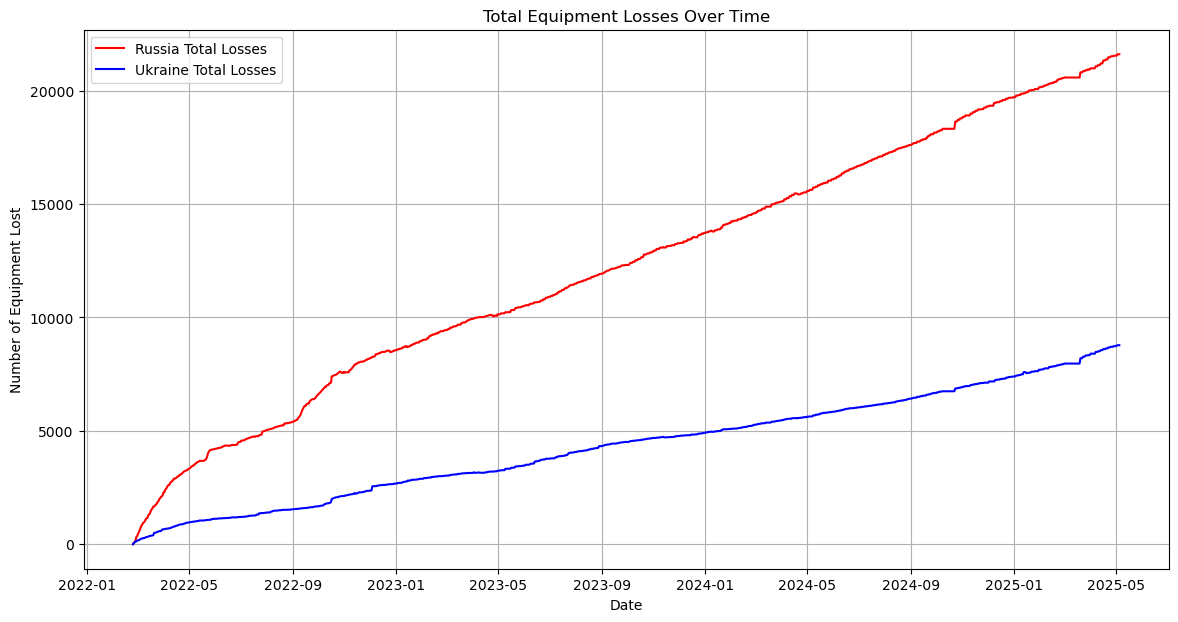

In [97]:
# Exploratory Data Analysis (EDA)
# ------------------------------

# Plotting overall equipment losses
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Russia_Total'], label='Russia Total Losses', color='red')
plt.plot(df.index, df['Ukraine_Total'], label='Ukraine Total Losses', color='blue')
plt.title('Total Equipment Losses Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Equipment Lost')
plt.legend()
plt.grid(True)
plt.show()

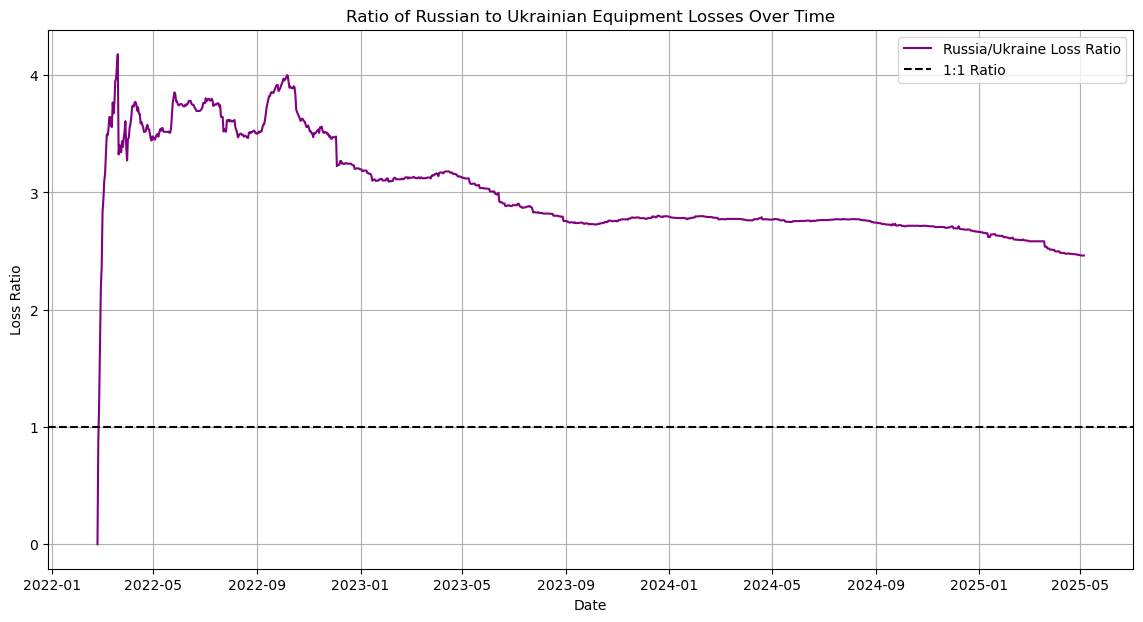

In [98]:
# Plotting ratio of losses
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Ratio RU/UA'], label='Russia/Ukraine Loss Ratio', color='purple')
plt.axhline(y=1, color='black', linestyle='--', label='1:1 Ratio')
plt.title('Ratio of Russian to Ukrainian Equipment Losses Over Time')
plt.xlabel('Date')
plt.ylabel('Loss Ratio')
plt.legend()
plt.grid(True)
plt.show()


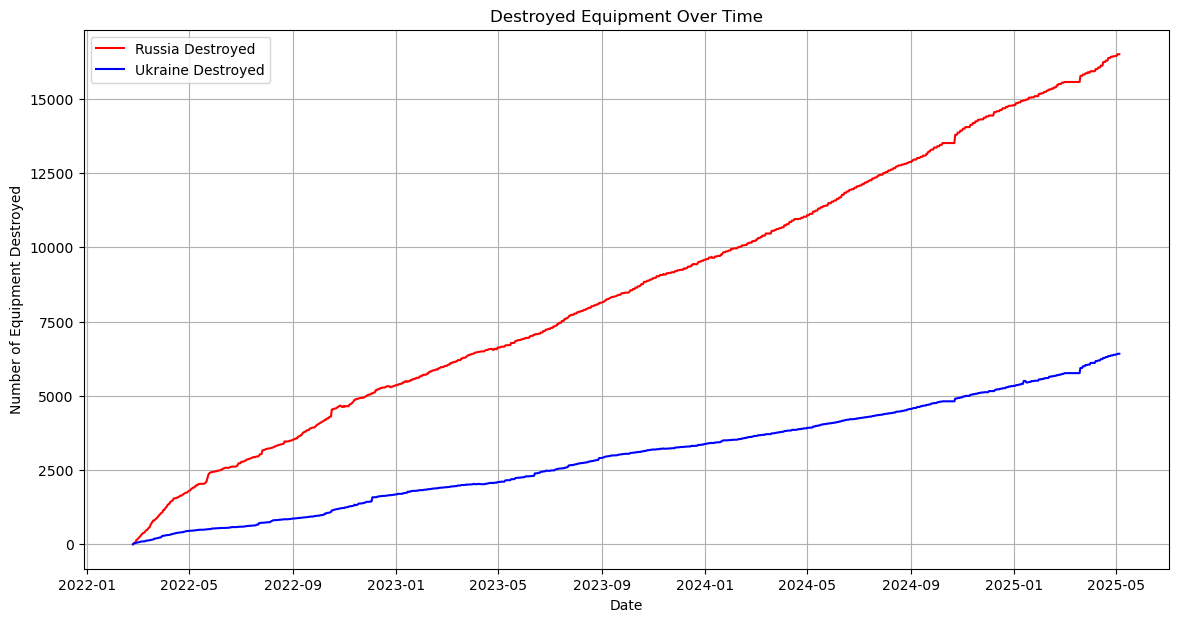

In [99]:
# Plotting destroyed equipment
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Russia_Destroyed'], label='Russia Destroyed', color='red')
plt.plot(df.index, df['Ukraine_Destroyed'], label='Ukraine Destroyed', color='blue')
plt.title('Destroyed Equipment Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Equipment Destroyed')
plt.legend()
plt.grid(True)
plt.show()

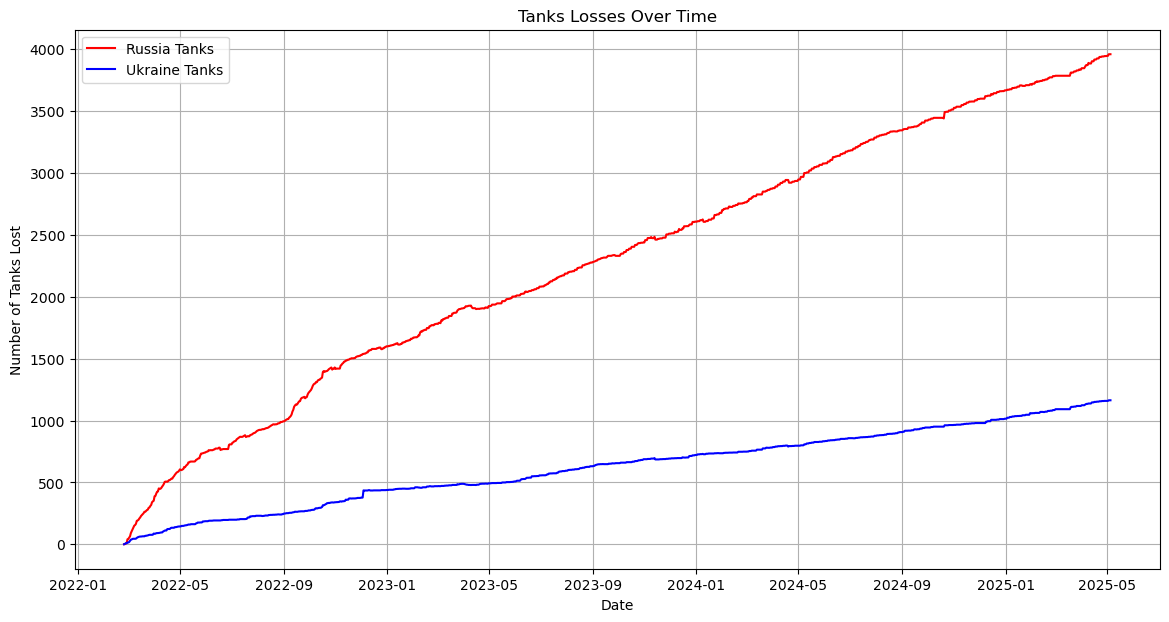

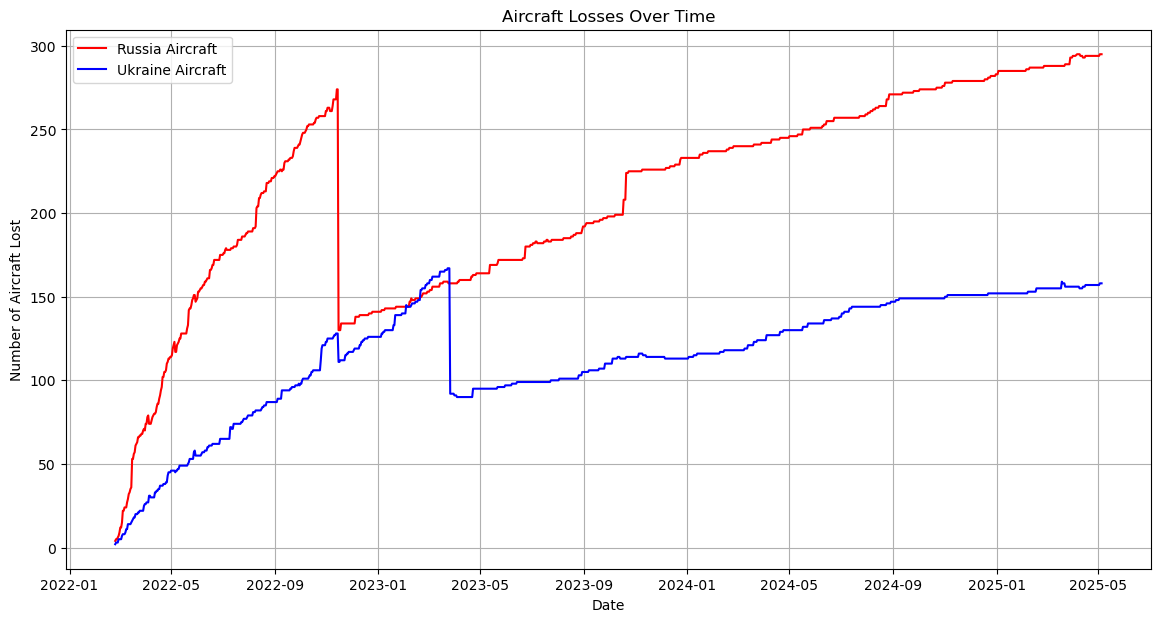

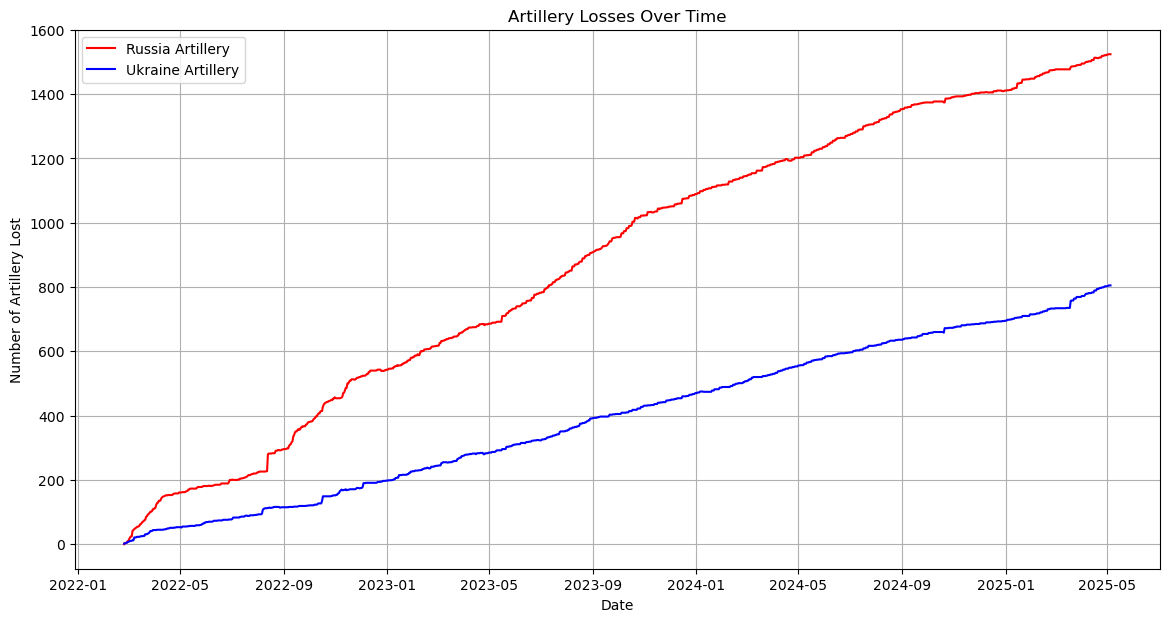

In [100]:
# Plotting specific equipment types
equipment_types = ['Tanks', 'Aircraft', 'Artillery']

for equipment in equipment_types:
    plt.figure(figsize=(14, 7))
    plt.plot(df.index, df[f'Russia_{equipment}'], label=f'Russia {equipment}', color='red')
    plt.plot(df.index, df[f'Ukraine_{equipment}'], label=f'Ukraine {equipment}', color='blue')
    plt.title(f'{equipment} Losses Over Time')
    plt.xlabel('Date')
    plt.ylabel(f'Number of {equipment} Lost')
    plt.legend()
    plt.grid(True)
plt.show()

In [101]:
# Check for negative differences (which cause drops in cumulative count)
df['rus_aircraft_daily_change'] = df['Russia_Aircraft'].diff()
negative_changes = df[df['rus_aircraft_daily_change'] < 0]
print(negative_changes[['Russia_Aircraft', 'rus_aircraft_daily_change']])

            Russia_Aircraft  rus_aircraft_daily_change
Date                                                  
2022-03-31               70                       -1.0
2022-04-05               74                       -5.0
2022-05-06              117                       -6.0
2022-05-30              147                       -4.0
2022-07-06              178                       -1.0
2022-09-09              225                       -1.0
2022-11-05              261                       -2.0
2022-11-15              130                     -144.0
2023-02-10              148                       -1.0
2023-03-25              158                       -1.0
2023-07-08              182                       -1.0
2023-07-21              183                       -1.0
2025-04-10              294                       -1.0
2025-04-13              293                       -1.0


In [102]:
# Check for negative differences (which cause drops in cumulative count)
df['ukr_aircraft_daily_change'] = df['Ukraine_Aircraft'].diff()
negative_changes = df[df['ukr_aircraft_daily_change'] < 0]
print(negative_changes[['Ukraine_Aircraft', 'ukr_aircraft_daily_change']])

            Ukraine_Aircraft  ukr_aircraft_daily_change
Date                                                   
2022-04-07                30                       -1.0
2022-05-06                45                       -1.0
2022-05-30                55                       -3.0
2022-07-12                71                       -1.0
2022-09-30                97                       -1.0
2022-11-15               111                      -17.0
2023-02-04               144                       -1.0
2023-03-27                92                      -75.0
2023-04-01                91                       -1.0
2023-04-04                90                       -1.0
2023-10-14               113                       -1.0
2023-11-10               115                       -1.0
2023-11-14               114                       -1.0
2023-12-06               113                       -1.0
2025-03-20               158                       -1.0
2025-03-23               156                    

In [103]:
# Find the drop amount on 2023-03-27
drop_date = '2023-03-27'
drop_value = df.loc[df.index == drop_date, 'Ukraine_Aircraft'].values[0]
prev_value = df.loc[df.index < drop_date, 'Ukraine_Aircraft'].max()  # Last value before drop

drop_amount = prev_value - drop_value  # How much was subtracted?

# Apply correction: Reduce all values AFTER the drop by the same amount
df['Ukraine_Aircraft'] = df['Ukraine_Aircraft'].copy()
df.loc[df.index >= drop_date, 'Ukraine_Aircraft'] += drop_amount

In [104]:
# Find the drop amount on 2022-11-15
drop_date = '2022-11-15'
drop_value = df.loc[df.index == drop_date, 'Russia_Aircraft'].values[0]
prev_value = df.loc[df.index < drop_date, 'Russia_Aircraft'].max()  # Last value before drop

drop_amount = prev_value - drop_value  # How much was subtracted?

# Apply correction: Reduce all values AFTER the drop by the same amount
df['Russia_Aircraft'] = df['Russia_Aircraft'].copy()
df.loc[df.index >= drop_date, 'Russia_Aircraft'] += drop_amount

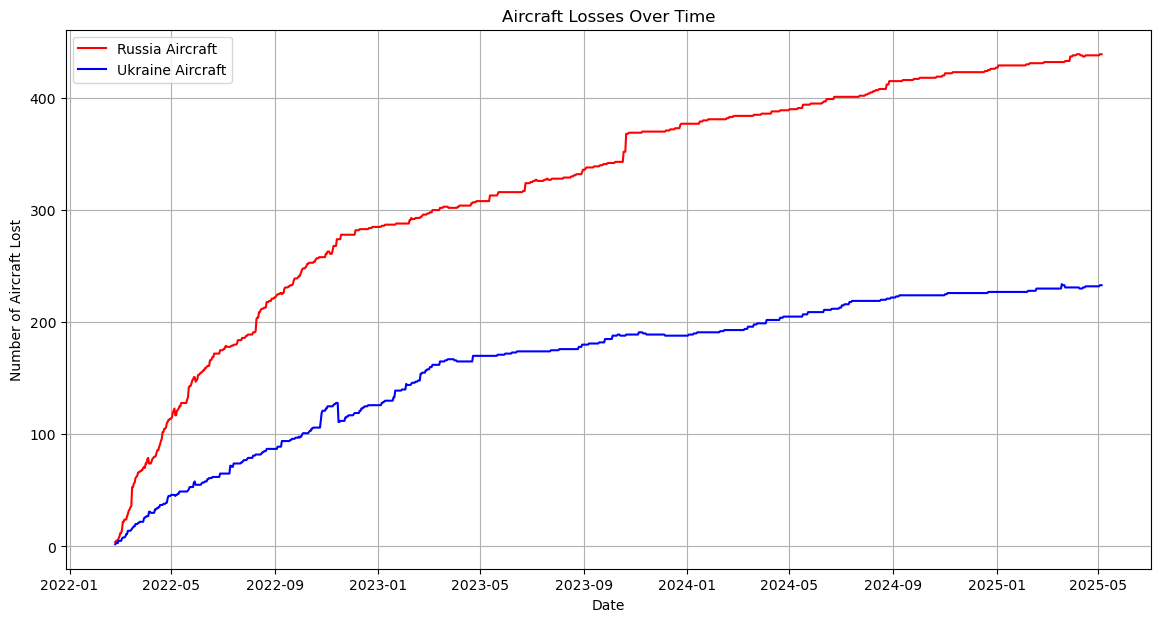

In [105]:
# Plotting specific equipment types
equipment_types = ['Aircraft']

for equipment in equipment_types:
    plt.figure(figsize=(14, 7))
    plt.plot(df.index, df[f'Russia_{equipment}'], label=f'Russia {equipment}', color='red')
    plt.plot(df.index, df[f'Ukraine_{equipment}'], label=f'Ukraine {equipment}', color='blue')
    plt.title(f'{equipment} Losses Over Time')
    plt.xlabel('Date')
    plt.ylabel(f'Number of {equipment} Lost')
    plt.legend()
    plt.grid(True)
plt.show()

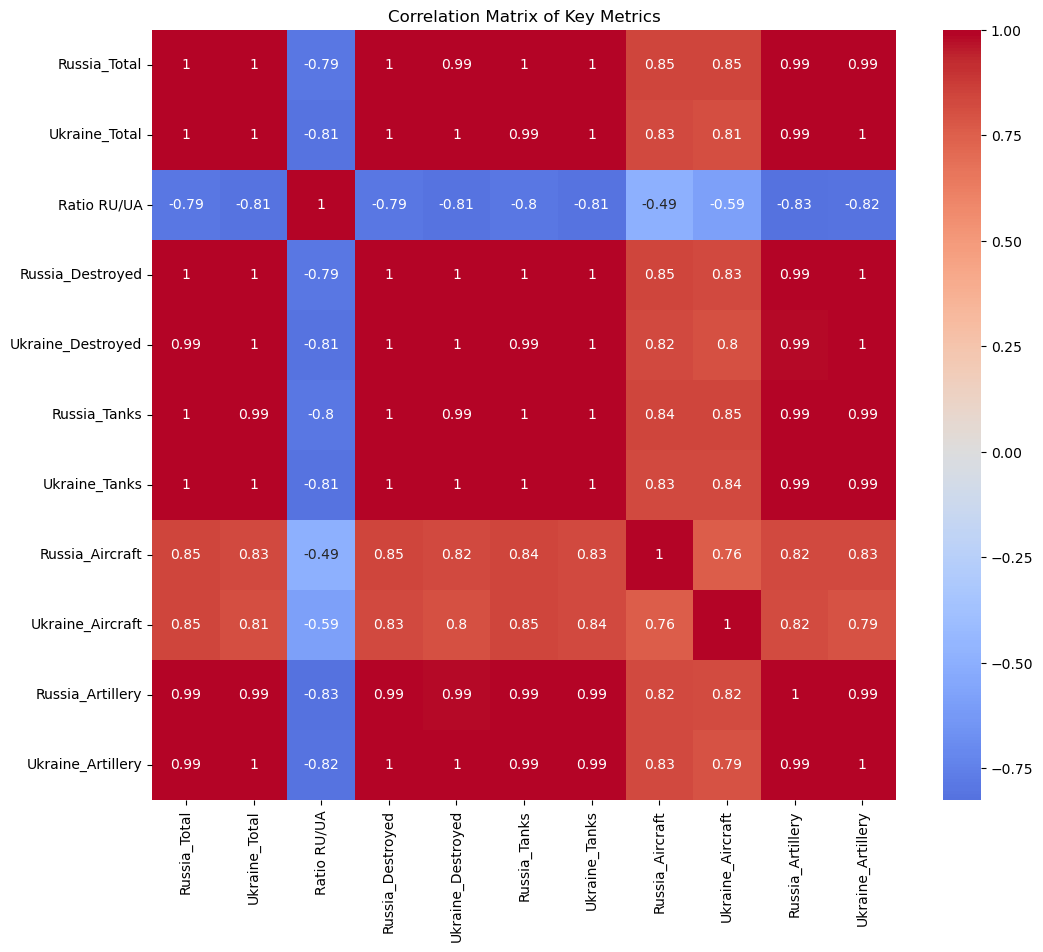

In [106]:
# Data Analysis
# -------------

# Calculate correlation matrix
corr_matrix = key_metrics.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Key Metrics')
plt.show()

## Perfect correlation is suspicious
### Further investigate

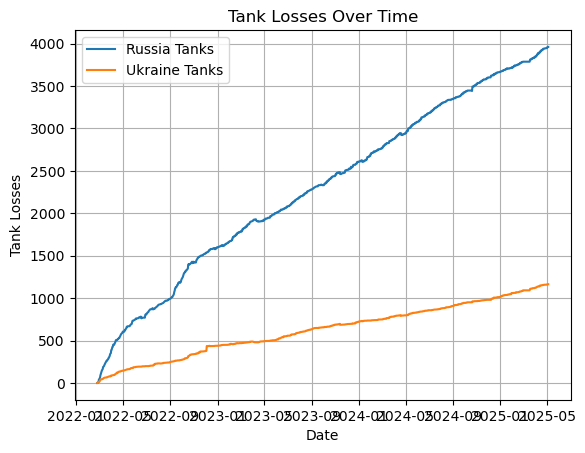

In [108]:
plt.plot(df.index, df['Russia_Tanks'], label='Russia Tanks')
plt.plot(df.index, df['Ukraine_Tanks'], label='Ukraine Tanks')
plt.legend()
plt.title("Tank Losses Over Time")
plt.xlabel("Date")
plt.ylabel("Tank Losses")
plt.grid(True)
plt.show()


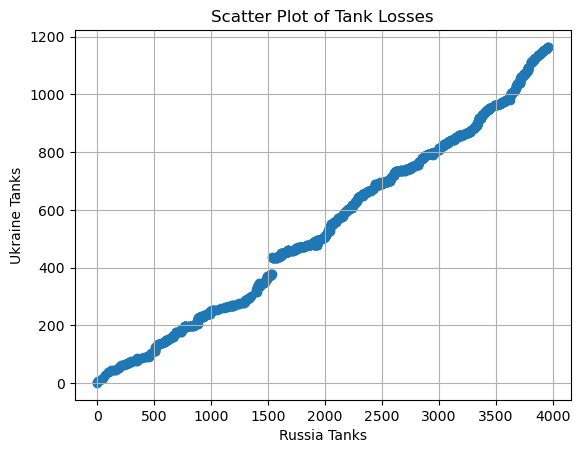

In [109]:
plt.scatter(df['Russia_Tanks'], df['Ukraine_Tanks'])
plt.xlabel('Russia Tanks')
plt.ylabel('Ukraine Tanks')
plt.title('Scatter Plot of Tank Losses')
plt.grid(True)
plt.show()


In [110]:
df[['Russia_Tanks', 'Ukraine_Tanks']].corr()

,Russia_Tanks,Ukraine_Tanks
Russia_Tanks,1.000000,0.997231
Ukraine_Tanks,0.997231,1.000000


### The losses are likely strongly associated, which could point to:

    Symmetrical combat operations

    Similar reporting windows

    A shared escalation timeline (e.g., both sides increased tank deployments together)

In [112]:
# Finding whether daily changes move together
df['Russia_Tank_Change'] = df['Russia_Tanks'].diff()
df['Ukraine_Tank_Change'] = df['Ukraine_Tanks'].diff()
df[['Russia_Tank_Change', 'Ukraine_Tank_Change']].corr()

,Russia_Tank_Change,Ukraine_Tank_Change
Russia_Tank_Change,1.000000,0.344974
Ukraine_Tank_Change,0.344974,1.000000


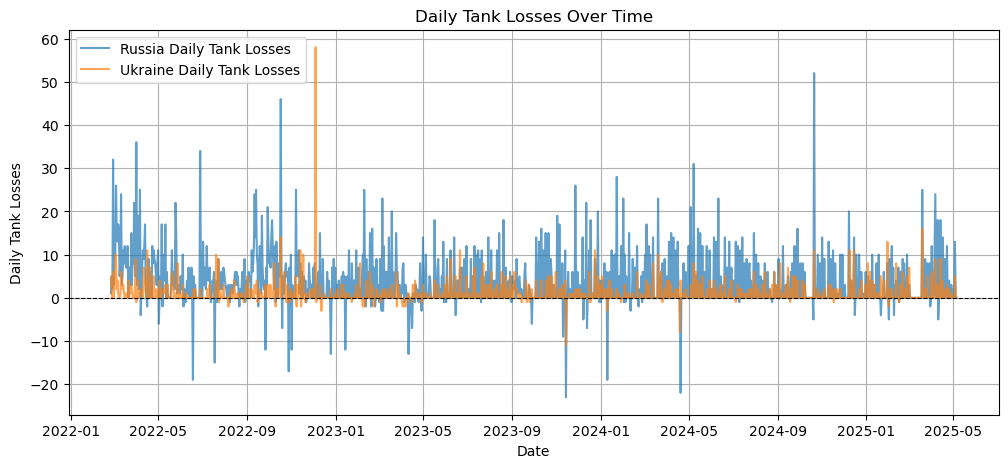

In [113]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(df.index, df['Russia_Tank_Change'], label='Russia Daily Tank Losses', alpha=0.7)
plt.plot(df.index, df['Ukraine_Tank_Change'], label='Ukraine Daily Tank Losses', alpha=0.7)
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.title('Daily Tank Losses Over Time')
plt.xlabel('Date')
plt.ylabel('Daily Tank Losses')
plt.legend()
plt.grid(True)
plt.show()

### Clip the changes which are negative since they could be errors

In [115]:
# Clip negative values to zero (keep only valid positive losses)
df['Russia_Tank_Change'] = df['Russia_Tank_Change'].clip(lower=0)
df['Ukraine_Tank_Change'] = df['Ukraine_Tank_Change'].clip(lower=0)

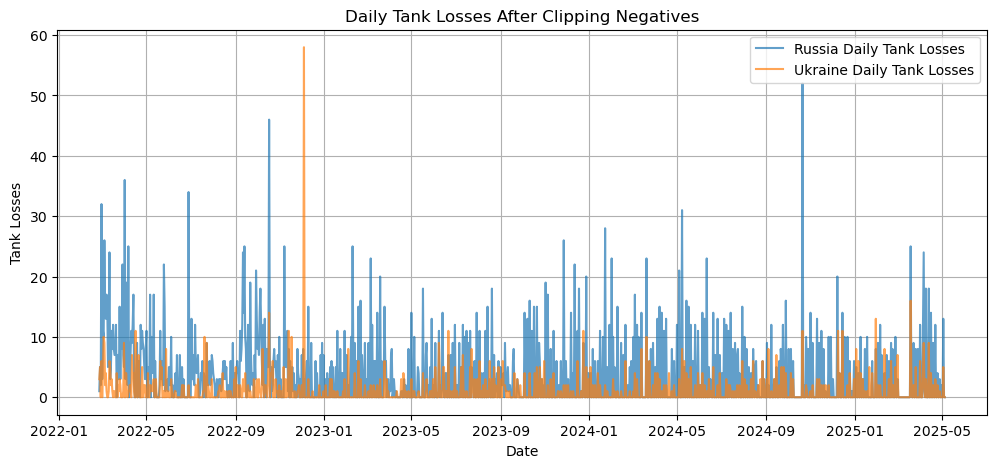

In [116]:
plt.figure(figsize=(12, 5))
plt.plot(df.index, df['Russia_Tank_Change'], label='Russia Daily Tank Losses', alpha=0.7)
plt.plot(df.index, df['Ukraine_Tank_Change'], label='Ukraine Daily Tank Losses', alpha=0.7)
plt.title('Daily Tank Losses After Clipping Negatives')
plt.xlabel('Date')
plt.ylabel('Tank Losses')
plt.legend()
plt.grid(True)
plt.show()


In [117]:
corr = df[['Russia_Tank_Change', 'Ukraine_Tank_Change']].corr().iloc[0, 1]
print(f"Correlation of Daily Tank Losses (post-clipping): {corr:.3f}")

Correlation of Daily Tank Losses (post-clipping): 0.361


In [118]:
rus_thresh = df['Russia_Tank_Change'].quantile(0.90)
ukr_thresh = df['Ukraine_Tank_Change'].quantile(0.90)

# Create spike flags
df['Russia_Spike'] = df['Russia_Tank_Change'] > rus_thresh
df['Ukraine_Spike'] = df['Ukraine_Tank_Change'] > ukr_thresh

# Check days when both spike
simultaneous_spikes = df[df['Russia_Spike'] & df['Ukraine_Spike']]

print(f"📅 Number of days both sides had spike tank losses: {len(simultaneous_spikes)}")
display(simultaneous_spikes[['Russia_Tank_Change', 'Ukraine_Tank_Change']])


📅 Number of days both sides had spike tank losses: 24


,Russia_Tank_Change,Ukraine_Tank_Change
Date,,
2022-02-28,32.0,6.0
2022-03-04,26.0,9.0
2022-03-11,24.0,6.0
2022-10-17,46.0,14.0
2023-02-17,15.0,6.0
2023-03-25,15.0,6.0
2023-06-30,12.0,5.0
2023-07-11,12.0,7.0
2023-10-21,15.0,5.0


### This will show how often both sides experienced unusually high losses on the same day, which could suggest:

    Major battles

    Artillery duels

    Strategic offensives

    For instance:
        2022-02-28 - Early days of the full-scale invasion (Battle of Kyiv, Kharkiv, and other cities began in late February 2022)

In [193]:
# Convert the datetime index to ordinal (number of days since 1 AD)
date_ordinal = df.index.map(pd.Timestamp.toordinal)

# Compute correlation
russia_corr = df['Russia_Total'].corr(pd.Series(date_ordinal, index=df.index))
ukraine_corr = df['Ukraine_Total'].corr(pd.Series(date_ordinal, index=df.index))

print("Correlation of Russia_Total with date:", russia_corr)
print("Correlation of Ukraine_Total with date:", ukraine_corr)

Correlation of Russia_Total with date: 0.996033427461341
Correlation of Ukraine_Total with date: 0.9979043017005389


In [209]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from math import sqrt

# Convert datetime index to ordinal for regression
date_nums = df.index.map(pd.Timestamp.toordinal).to_numpy().reshape(-1, 1)

# Extract time series data
russia_ts = df['Russia_Total'].to_numpy()
ukraine_ts = df['Ukraine_Total'].to_numpy()

# Reserve the last 30 days for testing
train_size = len(russia_ts) - 30

# Split data
X_train = date_nums[:train_size]
X_test = date_nums[train_size:]

y_train_rus = russia_ts[:train_size]
y_test_rus = russia_ts[train_size:]

y_train_ukr = ukraine_ts[:train_size]
y_test_ukr = ukraine_ts[train_size:]

# Train Linear Regression for Russia
model_rus_linear = LinearRegression()
model_rus_linear.fit(X_train, y_train_rus)
forecast_rus_linear = model_rus_linear.predict(X_test)

# Train Linear Regression for Ukraine
model_ukr_linear = LinearRegression()
model_ukr_linear.fit(X_train, y_train_ukr)
forecast_ukr_linear = model_ukr_linear.predict(X_test)

# Evaluate forecast accuracy using RMSE
rmse_rus = sqrt(mean_squared_error(y_test_rus, forecast_rus_linear))
rmse_ukr = sqrt(mean_squared_error(y_test_ukr, forecast_ukr_linear))

# Print RMSE values
print(f"Russia Forecast RMSE: {rmse_rus:.2f}")
print(f"Ukraine Forecast RMSE: {rmse_ukr:.2f}")


Russia Forecast RMSE: 248.80
Ukraine Forecast RMSE: 505.67


In [211]:
# Data Prediction (Forecasting)
# ----------------------------

# Extract total cumulative losses time series for both Russia and Ukraine
russia_ts = df['Russia_Total']
ukraine_ts = df['Ukraine_Total']

# Reserve the last 30 days of data for testing, use the rest for training
train_size = len(russia_ts) - 30
train_rus, test_rus = russia_ts[0:train_size], russia_ts[train_size:]
train_ukr, test_ukr = ukraine_ts[0:train_size], ukraine_ts[train_size:]

# Fit ARIMA model (order=2,1,2) on Russia's training data
model_rus_arima = ARIMA(train_rus, order=(2,1,2))
model_rus_fit = model_rus_arima.fit()

# Forecast Russia's cumulative losses for the next 30 days (same as test set)
forecast_rus_arima = model_rus_fit.forecast(steps=30)

# Fit ARIMA model (order=2,1,2) on Ukraine's training data
model_ukr_arima = ARIMA(train_ukr, order=(2,1,2))
model_ukr_fit = model_ukr_arima.fit()

# Forecast Ukraine's cumulative losses for the next 30 days
forecast_ukr_arima = model_ukr_fit.forecast(steps=30)

# Evaluate forecast accuracy using RMSE (Root Mean Squared Error)
rmse_rus = sqrt(mean_squared_error(test_rus, forecast_rus_arima))
rmse_ukr = sqrt(mean_squared_error(test_ukr, forecast_ukr_arima))

# Print RMSE values to assess model performance
print(f"Russia Forecast RMSE: {rmse_rus:.2f}")
print(f"Ukraine Forecast RMSE: {rmse_ukr:.2f}")


Russia Forecast RMSE: 173.02
Ukraine Forecast RMSE: 65.35


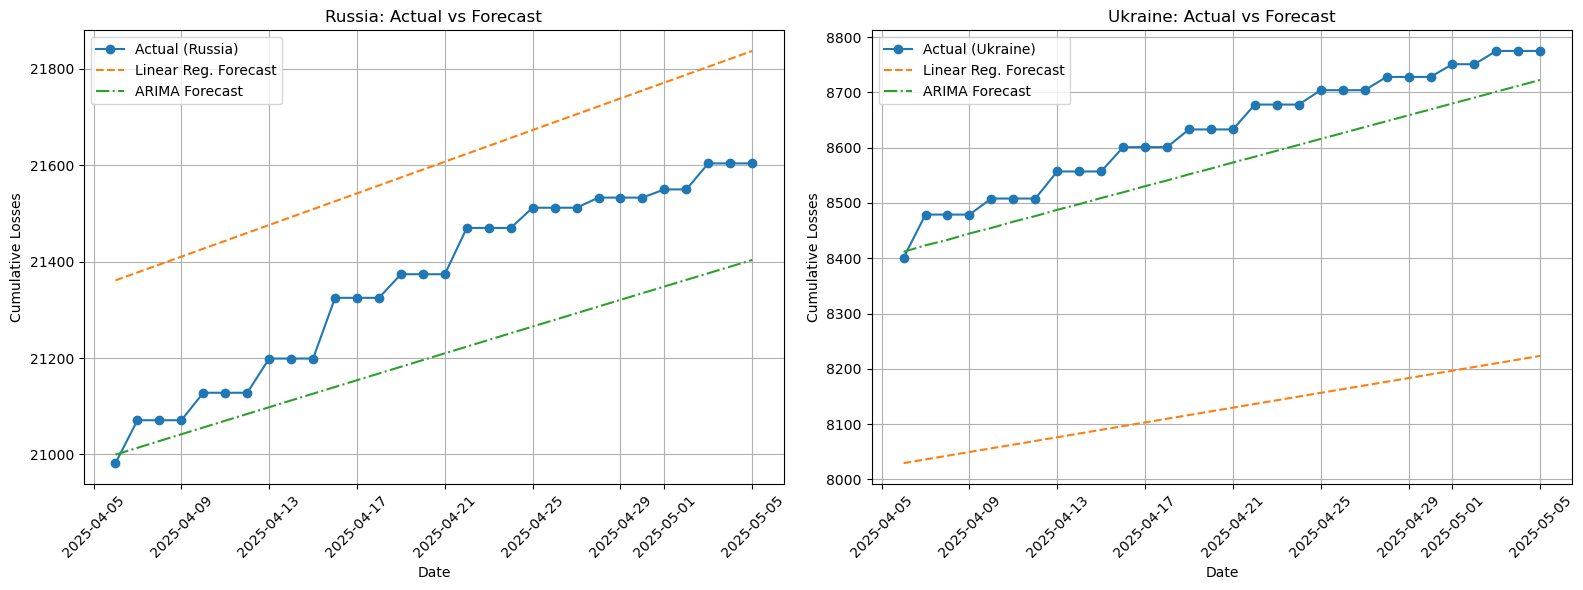

In [219]:
# Get the corresponding dates for the test set
test_dates = df.index[-30:]

plt.figure(figsize=(16, 6))

# Russia Plot
plt.subplot(1, 2, 1)
plt.plot(test_dates, y_test_rus, label='Actual (Russia)', marker='o')
plt.plot(test_dates, forecast_rus_linear, label='Linear Reg. Forecast', linestyle='--')           # Linear Regression
plt.plot(test_dates, forecast_rus_arima, label='ARIMA Forecast', linestyle='-.')          # ARIMA
plt.title('Russia: Actual vs Forecast')
plt.xlabel('Date')
plt.ylabel('Cumulative Losses')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

# Ukraine Plot
plt.subplot(1, 2, 2)
plt.plot(test_dates, y_test_ukr, label='Actual (Ukraine)', marker='o')
plt.plot(test_dates, forecast_ukr_linear, label='Linear Reg. Forecast', linestyle='--')          # Linear Regression
plt.plot(test_dates, forecast_ukr_arima, label='ARIMA Forecast', linestyle='-.')          # ARIMA
plt.title('Ukraine: Actual vs Forecast')
plt.xlabel('Date')
plt.ylabel('Cumulative Losses')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [221]:
# Forecast 180 days ahead for Russia
future_forecast_rus = model_rus_fit.forecast(steps=180)

# Forecast 180 days ahead for Ukraine
future_forecast_ukr = model_ukr_fit.forecast(steps=180)


In [223]:
# Use last timestamp from DatetimeIndex
last_date = df.index[-1]

# Generate 365 future dates
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=180)

# Create forecast DataFrame
forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Russia_Forecast': future_forecast_rus,
    'Ukraine_Forecast': future_forecast_ukr
})

# Save to CSV
forecast_df.to_csv('forecast.csv', index=False)


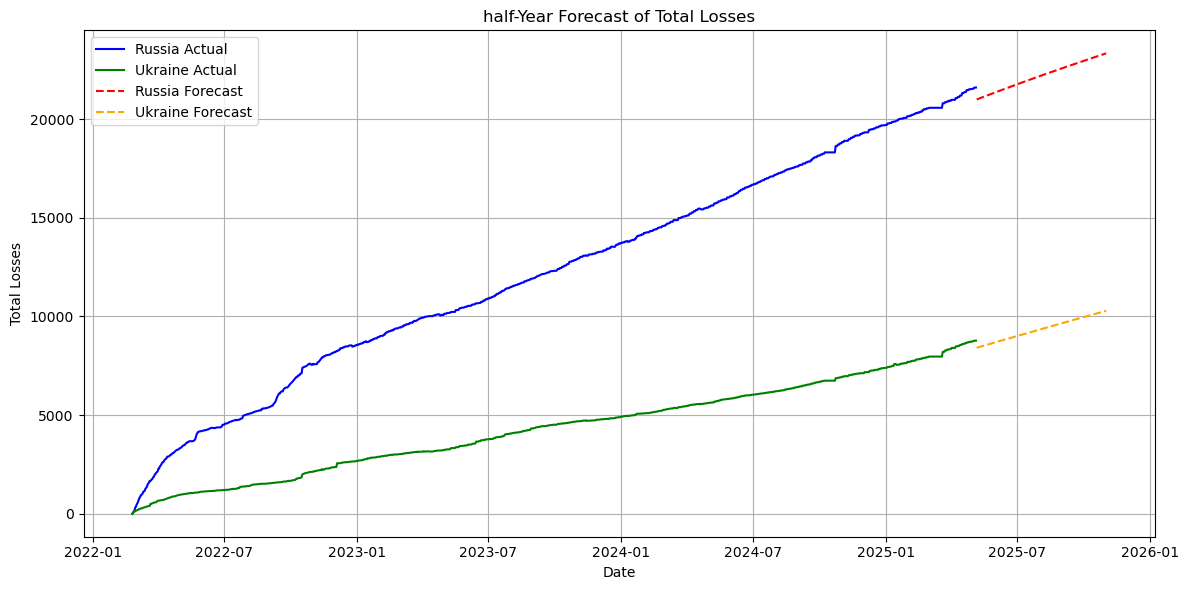

In [225]:
plt.figure(figsize=(12, 6))

# Plot historical data
plt.plot(df.index, df['Russia_Total'], label='Russia Actual', color='blue')
plt.plot(df.index, df['Ukraine_Total'], label='Ukraine Actual', color='green')

# Plot forecasted data
plt.plot(forecast_df['Date'], forecast_df['Russia_Forecast'], label='Russia Forecast', color='red', linestyle='--')
plt.plot(forecast_df['Date'], forecast_df['Ukraine_Forecast'], label='Ukraine Forecast', color='orange', linestyle='--')

plt.title('half-Year Forecast of Total Losses')
plt.xlabel('Date')
plt.ylabel('Total Losses')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [227]:
# Get the last known actual value
latest_rus_total = df['Russia_Total'].iloc[-1]
latest_ukr_total = df['Ukraine_Total'].iloc[-1]

# Get the final forecasted total after 1 year
forecasted_rus_total = future_forecast_rus.iloc[-1]
forecasted_ukr_total = future_forecast_ukr.iloc[-1]

# Compute expected additional losses
russia_additional = forecasted_rus_total - latest_rus_total
ukraine_additional = forecasted_ukr_total - latest_ukr_total

print(f"Forecasted Additional Russia Losses (next half year): {russia_additional:.0f}")
print(f"Forecasted Additional Ukraine Losses (next half year): {ukraine_additional:.0f}")


Forecasted Additional Russia Losses (next half year): 1733
Forecasted Additional Ukraine Losses (next half year): 1512


In [129]:
df.to_csv('ukr-rus-equipment_cleaned.csv', index=True)

In [131]:
df2 = pd.read_csv('ukr-rus-equipment_cleaned.csv')

In [135]:
df2.index = pd.to_datetime(df2.index)

In [136]:
df2['Date'] = pd.to_datetime(df2['Date'])